# ITR: Using nearest-neighbors to test causal rules

**Tangxiaoxue Zhang**

## Method's Current Usage

A major way researchers turn “patterns” into something closer to causal rules (in observational data) is nearest-neighbor matching: compare units that are similar on confounders but differ on the “treatment” (4 groups), so differences in outcomes are less plausibly driven by covariate imbalance. This approach is actively used and improved in the last five years, especially in settings where researchers must control for many covariates and where treatment is not binary.

First, modern theory work clarifies when nearest-neighbor (NN) matching can deliver statistically efficient causal estimates. Lin et al. (2023) show that NN matching can be viewed as estimating a density ratio, and that letting the number of neighbors grow with sample size can yield doubly robust and (under smoothness conditions) semiparametrically efficient estimation of average treatment effects—i.e., matching is not merely a heuristic, but can be theoretically well-grounded when implemented carefully.

Second, there is renewed focus on “how many neighbors?” and how to match well when covariates are high-dimensional. Zhang et al. (2025) propose Dynamic K-Nearest Neighbor Matching (DK-NNM), which chooses the effective K in a data-driven way (rather than using one fixed K globally), and also uses propensity/prognostic scores to reduce the curse of dimensionality in matching. The motivation maps closely onto my situation: if some of four groups occupy dense regions of feature space while others are sparse, a fixed K may either overfit (too few neighbors) or create poor matches (too many dissimilar neighbors).

Third, multi-arm “treatments” (4 groups) are now treated as first-class, rather than being forced into pairwise contrasts. Scotina et al. (2020) propose a nearest-neighbors matching estimator designed for multiple nominal treatments, using generalized propensity scores and matched imputation logic to estimate causal effects across more than two groups. That paper is especially relevant to my goal of comparing 4 groups while ruling out confounders like mem_A, mem_B, sim_AB, sim_AC, etc.

Taken together, recent work treats nearest-neighbor matching as a scalable causal design tool: (i) it is theoretically sharpened, (ii) tuned for high-dimensional covariates, and (iii) extended to multi-group comparisons—exactly the ingredients needed if my project aims to produce interpretable “rules” that are not artifacts of imbalanced covariates.

## Test on my data

### Generate data

#### Folder structure [could refer to "../example file structure"]:
- ComfyUI
    - ...
    - input
        - things_images
            - ...
            - granola
                - granola_01b.jpg
                - ...
                - granola_17s.jpg
            - ...
            - grapefruit
                - grapefruit_01b.jpg
                - ...
                - grapefruit_18n.jpg
            - ...
    - ...
- macs-40123-ztxxkaty
    - data
        - ...
        - pairs.txt
        - ...
    - ...
- resmem
    - object_images (*equal to "/things_images" in ComfyUI)
    - Pictures
    - resmem
    - memorability.ipynb
    - paris.txt
- run.py

#### Generating data

1. Get concept-pairs within 4 groups
    - calculate semantic similarity(300-dim vector) using cosine similarity.
    - form 4 groups
        - **H**igh semantic similarity, **S**ame category
        - **L**ow  semantic similarity, **S**ame category
        - **H**igh semantic similarity, **D**ifferent category
        - **L**ow  semantic similarity, **D**ifferent category

In [66]:
with open("pairs.txt") as f:
    pairs = f.readlines()

In [68]:
group_lst = ["HS", "LS", "HD", "LD"]
count_max = 40

group_dict = {}
for index, row in enumerate(pairs):
    concept = row.split(", ")
    comb = concept[0].replace(" ","_") + "+" + concept[1][:-1].replace(" ","_")
    group_dict[comb] = (group_lst[index//count_max], float(semantic_sim[index]))

group_dict

{'grapefruit+granola': ('HS', 0.9748241713933846),
 'coffee_bean+coffee': ('HS', 0.9393628685422709),
 'roll+airbag': ('HS', 0.9308706440558693),
 'poinsettia+airbag': ('HS', 0.9305323018157886),
 'penlight+penholder': ('HS', 0.9267487898571626),
 'revolver+nail_clippers': ('HS', 0.9204037782291271),
 'nail_clippers+jukebox': ('HS', 0.9184441732443607),
 'revolver+jukebox': ('HS', 0.91635634421389),
 'pineapple+pine_tree': ('HS', 0.9163399876213137),
 'wallpaper+tape_recorder': ('HS', 0.9143269933266321),
 'taffy+tadpole': ('HS', 0.912470720030395),
 'kangaroo+canoe': ('HS', 0.9110829966705449),
 'stiletto+starfish': ('HS', 0.9101965290089883),
 'printer+hobbyhorse': ('HS', 0.9055822674378285),
 'stir_fry+stingray': ('HS', 0.9036130692136678),
 'swab+bikini': ('HS', 0.9023323376211904),
 'vegetable+cello': ('HS', 0.8994121083571043),
 'tape_recorder+pantsuit': ('HS', 0.8984226787893091),
 'kiwi+ankle': ('HS', 0.8966333340787033),
 'roll+poinsettia': ('HS', 0.8929408320256588),
 'punchi

In [ ]:
# import json

# with open("group_dict.json", "w") as f:
#     json.dump(group_dict, f)

In [38]:
import pandas as pd

vectors_path = "data/semantic_embedding.csv"
word_list_path = "data/word_list.csv"
concept_path = "data/concepts.tsv"

vectors = pd.read_csv(vectors_path, header=None)
word_list = pd.read_csv(word_list_path, header=None)
concept = pd.read_csv(concept_path, sep="\t")

column_category = ["Bottom-up Category (Human Raters)",\
                   "Top-down Category (WordNet)",\
                   "Top-down Category (manual selection)"]
concept_list = concept[column_category]

word_list.columns = ["Word"]
vectors.columns = [f"Dimension_{i}" for i in range(1, len(vectors.columns)+1)]
dataset = pd.concat([word_list, concept_list, vectors], axis=1)
dataset.index = range(1, len(dataset)+1)
dataset.head()

,Word,Bottom-up Category (Human Raters),Top-down Category (WordNet),Top-down Category (manual selection),Dimension_1,Dimension_2,Dimension_3,Dimension_4,Dimension_5,Dimension_6,...,Dimension_291,Dimension_292,Dimension_293,Dimension_294,Dimension_295,Dimension_296,Dimension_297,Dimension_298,Dimension_299,Dimension_300
1,aardvark,animal,animal,animal,0.002518,0.068236,-0.028361,0.166795,-0.065438,0.031492,...,-0.045665,0.011164,-0.005354,0.035327,-0.001382,0.077301,-0.083461,0.064104,-0.004183,0.046304
2,abacus,NaN,NaN,home decor,0.056792,-0.063938,-0.001322,0.045321,-0.038369,0.048631,...,-0.002180,0.041572,-0.017164,-0.052926,-0.051482,-0.040223,-0.066239,0.016329,-0.076589,-0.009422
3,accordion,musical instrument,musical instrument,musical instrument,0.027205,0.002443,-0.025440,0.022057,-0.027733,0.004925,...,0.018821,0.074330,-0.086789,-0.115503,0.019062,0.069380,0.001089,-0.006804,0.006405,0.036277
4,acorn,NaN,fruit,NaN,0.034074,0.006323,-0.079977,0.064698,-0.002513,-0.019950,...,0.012923,0.023666,-0.046211,-0.060001,0.047634,-0.036336,0.012826,-0.053503,-0.013425,0.059680
5,air conditioner,NaN,NaN,electronic device,0.001522,0.003388,-0.031035,-0.008351,-0.013928,0.066164,...,-0.048569,0.047054,-0.002966,0.038435,0.027077,-0.031518,-0.092717,0.145555,0.015335,0.023629


In [39]:
# To calculate similarity: select vector columns [Dimension_1 to Dimension_300]
column_selected_vector = dataset.columns[4:]
dataset_vector = dataset[column_selected_vector] # select only vector columns
# Remove rows with NaN values
dataset_vector = dataset_vector.loc[~dataset_vector["Dimension_1"].isna()]

In [40]:
dataset_vector.isna().sum().sum() # check if there is any NaN value

np.int64(0)

In [41]:
import numpy as np
def cosine_similarity(vector1, vector2):
    vec1 = np.array(vector1)
    vec2 = np.array(vector2)

    dot_product = np.dot(vec1, vec2)
    magnitude_v1 = np.linalg.norm(vec1)
    magnitude_v2 = np.linalg.norm(vec2)

    if magnitude_v1 == 0 or magnitude_v2 == 0:
        return 0

    return dot_product / (magnitude_v1 * magnitude_v2)

lst_values = dataset_vector.values.tolist()
lst_consine_similarity = [[0]*len(lst_values) for _ in lst_values]
for index_1, vec1 in enumerate(lst_values):
    for index_2, vec2 in enumerate(lst_values):
        if index_1 <= index_2:
            continue
        lst_consine_similarity[index_1][index_2] = cosine_similarity(vec1, vec2)

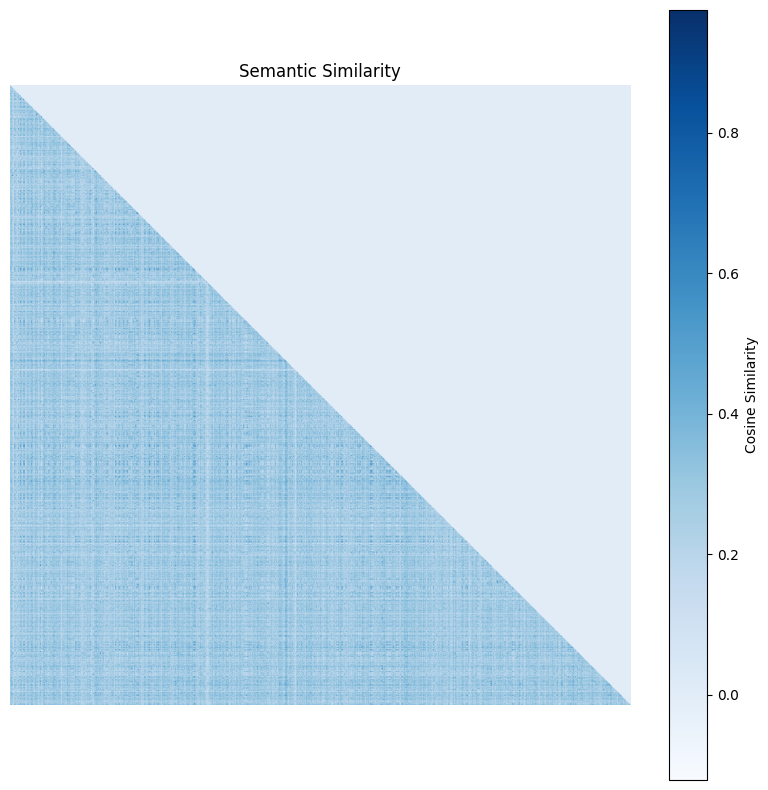

In [42]:
import matplotlib.pyplot as plt

# Convert to numpy array for easier manipulation
np_consine_similarity = np.array(lst_consine_similarity)
max_similarity = np_consine_similarity.max()
min_similarity = np_consine_similarity.min()

# Plot heatmap
plt.figure(figsize=(10, 10))  # size
plt.imshow(np_consine_similarity, cmap='Blues', vmin=min_similarity, vmax=max_similarity)
plt.colorbar(label='Cosine Similarity')
plt.title("Semantic Similarity")
plt.axis('off')
plt.show()

In [43]:
# 1. Find indices of non-zero elements
np_consine_similarity = np.array(lst_consine_similarity)
nonzero_indices = np.argwhere(np_consine_similarity != 0)

# 2. Extract the non-zero values
nonzero_values = np_consine_similarity[np_consine_similarity != 0]

# 3. Get the sorted indices of these non-zero values
sorted_indices = np.argsort(-nonzero_values)  # Negative sign for descending order

# 4. Get the sorted coordinates and values
sorted_coords = nonzero_indices[sorted_indices]
sorted_values = nonzero_values[sorted_indices]

# 5. print
count_max = 40
head = len(sorted_coords)//100
tail_start = len(sorted_coords) - head
tail_end = len(sorted_coords)

In [44]:
CATEGORY_COLS = [
    "Bottom-up Category (Human Raters)",
    "Top-down Category (WordNet)",
    "Top-down Category (manual selection)",
]

In [45]:
# pairs.txt
with open("pairs.txt", "w") as f:
    f.write("")
txt = open("pairs.txt", mode="a+")
semantic_sim = []

# image_folder -> detect polysemy
image_folder = pd.read_csv("data/image-paths.csv", header=None)
image_folder = image_folder.iloc[:,0]
folder_name = set()
for image_folder_tmp in image_folder:
    folder_name_tmp = image_folder_tmp.split("/")[1].replace("_"," ")
    folder_name.add(folder_name_tmp)
folder_name

{'cat',
 'camper',
 'stick',
 'turntable',
 'apron',
 'mole',
 'tricycle',
 'jumpsuit',
 'safety pin',
 'sea urchin',
 'peg',
 'bolo tie',
 'mousepad',
 'volleyball',
 'hearse',
 'leg',
 'lectern',
 'toy',
 'fireworks',
 'map',
 'llama',
 'pallet',
 'icepick',
 'tostada',
 'handle',
 'macadamia',
 'ram',
 'duckling',
 'hinge',
 'syringe',
 'painting',
 'rocking chair',
 'tarantula',
 'breathalyzer',
 'lifesaver',
 'firecracker',
 'baton1',
 'cooler',
 'veil',
 'shower curtain',
 'wine',
 'wheelchair',
 'tomato sauce',
 'lemon',
 'pastry',
 'basil',
 'wrap',
 'memory stick',
 'medal',
 'curry',
 'barcode',
 'jewelry',
 'compost',
 'crepe',
 'food processor',
 'shuffleboard',
 'insole',
 'berry',
 'mosquito',
 'quesadilla',
 'blower',
 'compass',
 'laptop',
 'scooter',
 'snowball',
 'tortellini',
 'trashcan',
 'pomegranate',
 'coaster',
 'hedge',
 'pillow',
 'coffee bean',
 'bench',
 'mint',
 'ball',
 'petal',
 'megaphone',
 'dirt bike',
 'sprinkler',
 'water bottle',
 'puppet',
 'casset

In [46]:
print("---------------------   Similar Paris within different category   ---------------------")
count = 0
for i in range(head):
    # for each group: limit number
    if count == count_max:
        break
    row, col = sorted_coords[i]
    word_row = dataset.iloc[row]['Word']
    word_col = dataset.iloc[col]['Word']
    if word_row == word_col:
        continue
    # ignore paperclip, car, which is highly correlated to different stuff, strange
    if word_row == "paperclip" or word_col == "paperclip" or word_row.split(" ")[0] == "car" or word_col.split(" ")[0] == "car":
        continue
    # make sure it's not polysemy
    if word_row not in folder_name or word_col not in folder_name:
        continue
    word_row_cate = {dataset.iloc[row][CATEGORY_COLS[0]], dataset.iloc[row][CATEGORY_COLS[1]], dataset.iloc[row][CATEGORY_COLS[2]]}
    for x in list(word_row_cate): 
        if x != x:
            word_row_cate.remove(x)
    word_col_cate = {dataset.iloc[col][CATEGORY_COLS[0]], dataset.iloc[col][CATEGORY_COLS[1]], dataset.iloc[col][CATEGORY_COLS[2]]}
    for x in list(word_col_cate): 
        if x != x:
            word_col_cate.remove(x)
    if (word_row_cate <= word_col_cate) or (word_row_cate >= word_col_cate):
        continue
    if not word_row_cate:
        continue
    if not word_row_cate:
        continue
    value = sorted_values[i]
    print(f"---{i}---")
    print(f"({word_row}, {word_col}): {value}")
    print(f"category: {word_row_cate} << vs >> {word_col_cate}")
    print()
    
    count += 1 # increment
    semantic_sim.append(value)
    txt.write(f"{word_row}, {word_col}\n") # write into the pairs.txt

---------------------   Similar Paris within different category   ---------------------
---0---
(grapefruit, granola): 0.9748241713933846
category: {'food, fruit', 'fruit'} << vs >> {'food'}

---13---
(coffee bean, coffee): 0.9393628685422709
category: {'food', 'fruit'} << vs >> {'food, beverage', 'drink'}

---19---
(roll, airbag): 0.9308706440558693
category: {'food'} << vs >> {'container', 'part of car'}

---20---
(poinsettia, airbag): 0.9305323018157886
category: {'plant'} << vs >> {'container', 'part of car'}

---23---
(penlight, penholder): 0.9267487898571626
category: {'medical equipment, tool'} << vs >> {'office supply'}

---27---
(revolver, nail clippers): 0.9204037782291271
category: {'weapon'} << vs >> {'tool'}

---30---
(nail clippers, jukebox): 0.9184441732443607
category: {'tool'} << vs >> {'electronic device'}

---31---
(revolver, jukebox): 0.91635634421389
category: {'weapon'} << vs >> {'electronic device'}

---32---
(pineapple, pine tree): 0.9163399876213137
category: {

In [47]:
print("---------------------   Similar Paris within the same category   ---------------------")
count = 0
for i in range(head):
    # for each group: limit number
    if count == count_max:
        break
    row, col = sorted_coords[i]
    word_row = dataset.iloc[row]['Word']
    word_col = dataset.iloc[col]['Word']
    if word_row == word_col:
        continue
    # ignore paperclip, car, which is highly correlated to different stuff, strange
    if word_row == "paperclip" or word_col == "paperclip" or word_row.split(" ")[0] == "car" or word_col.split(" ")[0] == "car":
        continue
    # make sure it's not polysemy
    if word_row not in folder_name or word_col not in folder_name:
        continue
    word_row_cate = {dataset.iloc[row][CATEGORY_COLS[0]], dataset.iloc[row][CATEGORY_COLS[1]], dataset.iloc[row][CATEGORY_COLS[2]]}
    for x in list(word_row_cate): 
        if x != x:
            word_row_cate.remove(x)
    word_col_cate = {dataset.iloc[col][CATEGORY_COLS[0]], dataset.iloc[col][CATEGORY_COLS[1]], dataset.iloc[col][CATEGORY_COLS[2]]}
    for x in list(word_col_cate): 
        if x != x:
            word_col_cate.remove(x)
    if not ((word_row_cate >= word_col_cate) and (word_row_cate >= word_col_cate)):
        continue
    if not word_row_cate:
        continue
    if not word_col_cate:
        continue
    value = sorted_values[i]
    print(f"---{i}---")
    print(f"({word_row}, {word_col}): {value}")
    print(f"category: {word_row_cate} << vs >> {word_col_cate}")
    print()
    
    count += 1 # increment
    semantic_sim.append(value)
    txt.write(f"{word_row}, {word_col}\n") # write into the pairs.txt

---------------------   Similar Paris within the same category   ---------------------
---5---
(pepperoni, dogfood): 0.9610101483477153
category: {'food'} << vs >> {'food'}

---47---
(mole, deer): 0.9007321597370284
category: {'animal'} << vs >> {'animal'}

---60---
(blueberry, berry): 0.8835782478160507
category: {'food, fruit', 'fruit'} << vs >> {'food, fruit', 'fruit'}

---77---
(syrup, burrito): 0.8681031704639932
category: {'food'} << vs >> {'food'}

---105---
(ham, cheeseburger): 0.8550372282245138
category: {'food'} << vs >> {'food'}

---109---
(cello, bassoon): 0.8538244649413883
category: {'musical instrument'} << vs >> {'musical instrument'}

---118---
(clarinet, cello): 0.8512761206003383
category: {'musical instrument'} << vs >> {'musical instrument'}

---122---
(corkscrew, bottle opener): 0.8486313647707776
category: {'tool', 'kitchen tool, tool', 'kitchen tool'} << vs >> {'tool', 'kitchen tool, tool', 'kitchen tool'}

---123---
(clarinet, bassoon): 0.8483918485627824
cate

---269---
(dress, blouse): 0.810699200647184
category: {'clothing'} << vs >> {'clothing'}

---275---
(snowsuit, loincloth): 0.8096886702860174
category: {'clothing'} << vs >> {'clothing'}

---277---
(stingray, otter): 0.8092944732402475
category: {'animal'} << vs >> {'animal'}

---278---
(elbow, arm): 0.8092375790789677
category: {'body part'} << vs >> {'body part'}

---291---
(goblet, glass): 0.8070367194714543
category: {'container'} << vs >> {'container'}

---295---
(cabbage, asparagus): 0.8058435214872927
category: {'plant', 'plant, food, vegetable', 'vegetable'} << vs >> {'plant, food, vegetable', 'vegetable'}

---299---
(coyote, cougar): 0.805306668902298
category: {'animal'} << vs >> {'animal'}

---316---
(cantaloupe, banana): 0.8031426492996334
category: {'food, fruit', 'fruit'} << vs >> {'food, fruit', 'fruit'}

---326---
(broccoli, bok choy): 0.802225248101149
category: {'plant', 'plant, food, vegetable', 'vegetable'} << vs >> {'plant', 'plant, food, vegetable', 'vegetable'}


In [48]:
print("---------------------   Dissimilar Paris within different category  ---------------------")
count = 0
for i in range(tail_end-1, tail_start, -1):
    # for each group: limit number
    if count == count_max:
        break
    row, col = sorted_coords[i]
    word_row = dataset.iloc[row]['Word']
    word_col = dataset.iloc[col]['Word']
    if word_row == word_col:
        continue
    # make sure it's not polysemy
    if word_row not in folder_name or word_col not in folder_name:
        continue
    word_row_cate = {dataset.iloc[row][CATEGORY_COLS[0]], dataset.iloc[row][CATEGORY_COLS[1]], dataset.iloc[row][CATEGORY_COLS[2]]}
    for x in list(word_row_cate): 
        if x != x:
            word_row_cate.remove(x)
    word_col_cate = {dataset.iloc[col][CATEGORY_COLS[0]], dataset.iloc[col][CATEGORY_COLS[1]], dataset.iloc[col][CATEGORY_COLS[2]]}
    for x in list(word_col_cate): 
        if x != x:
            word_col_cate.remove(x)
    if (word_row_cate <= word_col_cate) or (word_row_cate >= word_col_cate):
        continue
    if not word_row_cate:
        continue
    if not word_row_cate:
        continue
    value = sorted_values[i]
    print(f"---{i}---")
    print(f"({word_row}, {word_col}): {value}")
    print(f"category: {word_row_cate} << vs >> {word_col_cate}")
    print()
    
    count += 1 # increment
    semantic_sim.append(value)
    txt.write(f"{word_row}, {word_col}\n") # write into the pairs.txt

---------------------   Dissimilar Paris within different category  ---------------------
---1699245---
(seatbelt, pencil): -0.12158587001929161
category: {'clothing', 'part of car'} << vs >> {'office supply, tool'}

---1699237---
(tricycle, pencil): -0.07375403783242152
category: {'toy', 'vehicle', 'container, vehicle'} << vs >> {'office supply, tool'}

---1699235---
(pencil, drink): -0.07292069237029399
category: {'office supply, tool'} << vs >> {'drink'}

---1699231---
(pencil, ambulance): -0.07150797207007868
category: {'office supply, tool'} << vs >> {'vehicle', 'container, vehicle'}

---1699227---
(seatbelt, dreidel): -0.06780870082656891
category: {'clothing', 'part of car'} << vs >> {'toy'}

---1699219---
(squirt gun, jet): -0.05950443582532609
category: {'toy'} << vs >> {'vehicle'}

---1699218---
(poppy, penholder): -0.05919984556084294
category: {'plant', 'plant, food'} << vs >> {'office supply'}

---1699217---
(pencil, ferry): -0.059081135966513716
category: {'office supply,

In [49]:
print("---------------------   Dissimilar Paris within the same category  ---------------------")
count = 0
for i in range(tail_end-1, tail_start, -1):
    # for each group: limit number
    if count == count_max:
        break
    row, col = sorted_coords[i]
    word_row = dataset.iloc[row]['Word']
    word_col = dataset.iloc[col]['Word']
    if word_row == word_col:
        continue
    # make sure it's not polysemy
    if word_row not in folder_name or word_col not in folder_name:
        continue
    word_row_cate = {dataset.iloc[row][CATEGORY_COLS[0]], dataset.iloc[row][CATEGORY_COLS[1]], dataset.iloc[row][CATEGORY_COLS[2]]}
    for x in list(word_row_cate): 
        if x != x:
            word_row_cate.remove(x)
    word_col_cate = {dataset.iloc[col][CATEGORY_COLS[0]], dataset.iloc[col][CATEGORY_COLS[1]], dataset.iloc[col][CATEGORY_COLS[2]]}
    for x in list(word_col_cate): 
        if x != x:
            word_col_cate.remove(x)
    if not ((word_row_cate >= word_col_cate) and (word_row_cate >= word_col_cate)):
        continue
    if not word_row_cate:
        continue
    if not word_col_cate:
        continue
    value = sorted_values[i]
    print(f"---{i}---")
    print(f"({word_row}, {word_col}): {value}")
    print(f"category: {word_row_cate} << vs >> {word_col_cate}")
    print()

    count += 1 # increment
    semantic_sim.append(value)
    txt.write(f"{word_row}, {word_col}\n") # write into the pairs.txt

---------------------   Dissimilar Paris within the same category  ---------------------
---1699072---
(wetsuit, crown): -0.028634503180206144
category: {'clothing', 'sports equipment, clothing'} << vs >> {'clothing'}

---1699053---
(gumdrop, cordon bleu): -0.026637505716031996
category: {'food'} << vs >> {'food'}

---1698961---
(soy sauce, omelet): -0.020116148551774356
category: {'food'} << vs >> {'food'}

---1698880---
(teacup, bucket): -0.015358767160827852
category: {'container'} << vs >> {'container'}

---1698876---
(wetsuit, armor): -0.015140823011065719
category: {'clothing', 'sports equipment, clothing'} << vs >> {'clothing'}

---1698862---
(soy sauce, cordon bleu): -0.014644878034747687
category: {'food'} << vs >> {'food'}

---1698663---
(roll, cordon bleu): -0.005165264355343986
category: {'food'} << vs >> {'food'}

---1698632---
(salami, lollipop): -0.004242969725268177
category: {'food'} << vs >> {'food'}

---1698603---
(sugar cube, cordon bleu): -0.0034227415922318595
cat

In [50]:
txt.close()

In [51]:
# add semantic similarity to memorabiltiy_tagged.json
import json
with open('data/memorability_tagged.json', "r") as f:
    tagged_memo = json.load(f)



2. Generate picture-pairs using ComfyUI
    - Start ComfyUI, whose default address is localhost:8188
    - run "run.py"

3. Calculate the memorability score of each picture using resmem
    - run "memorabiliy.ipynb"

### Causal-rules

In [1]:
method_tag = 0

In [2]:
tag_method_lst = ['CLIP', 'CLIP_pca', 'Pixel', 'Pixel_pca']
category_dict = {"HS": 0,
              "LS": 1,
              "HD": 2,
              "LD": 3}

In [3]:
import json
with open('data/memorability_tagged.json', "r") as f:
    tagged_memo = json.load(f)
index = [index for index, content in enumerate(tagged_memo) if content[tag_method_lst[method_tag]]["tag"]=="combination"]

#### visualization

In [4]:
import json
with open('data/memorability.json', "r") as f:
    memorabilty_lst = json.load(f)

memorabilty_lst = [memorabilty_lst[i] for i in index]

from collections import defaultdict
sums = defaultdict(float)
counts = defaultdict(int)

for d in memorabilty_lst:
    for k, v in d.items():
        if isinstance(v, (int, float)):
            sums[k] += v
            counts[k] += 1

means = {k: sums[k] / counts[k] for k in sums}
print(means)

{'grapefruit': 0.9186469316482544, 'granola': 0.8453173339366913, 'grapefruit+granola': 0.8675752580165863, 'coffee_bean': 0.9126856923103333, 'coffee': 0.8686797559261322, 'coffee_bean+coffee': 0.8237918317317963, 'roll': 0.925700144334273, 'airbag': 0.785389244556427, 'roll+airbag': 0.8243314772844315, 'poinsettia': 0.8074615171977452, 'poinsettia+airbag': 0.8130338042974472, 'penlight': 0.8465885147452354, 'penholder': 0.8786304672559102, 'penlight+penholder': 0.8498654291033745, 'revolver': 0.8736073136329651, 'nail_clippers': 0.8657850921154022, 'revolver+nail_clippers': 0.872272253036499, 'jukebox': 0.7862636297941208, 'nail_clippers+jukebox': 0.7956739962100983, 'revolver+jukebox': 0.8168308734893799, 'wallpaper': 0.8527150675654411, 'tape_recorder': 0.8460776954889297, 'wallpaper+tape_recorder': 0.7991427779197693, 'taffy': 0.8643827140331268, 'tadpole': 0.890996903181076, 'taffy+tadpole': 0.7815012633800507, 'kangaroo': 0.8507533818483353, 'canoe': 0.8184437884224786, 'kangaro

In [5]:
means

{'grapefruit': 0.9186469316482544,
 'granola': 0.8453173339366913,
 'grapefruit+granola': 0.8675752580165863,
 'coffee_bean': 0.9126856923103333,
 'coffee': 0.8686797559261322,
 'coffee_bean+coffee': 0.8237918317317963,
 'roll': 0.925700144334273,
 'airbag': 0.785389244556427,
 'roll+airbag': 0.8243314772844315,
 'poinsettia': 0.8074615171977452,
 'poinsettia+airbag': 0.8130338042974472,
 'penlight': 0.8465885147452354,
 'penholder': 0.8786304672559102,
 'penlight+penholder': 0.8498654291033745,
 'revolver': 0.8736073136329651,
 'nail_clippers': 0.8657850921154022,
 'revolver+nail_clippers': 0.872272253036499,
 'jukebox': 0.7862636297941208,
 'nail_clippers+jukebox': 0.7956739962100983,
 'revolver+jukebox': 0.8168308734893799,
 'wallpaper': 0.8527150675654411,
 'tape_recorder': 0.8460776954889297,
 'wallpaper+tape_recorder': 0.7991427779197693,
 'taffy': 0.8643827140331268,
 'tadpole': 0.890996903181076,
 'taffy+tadpole': 0.7815012633800507,
 'kangaroo': 0.8507533818483353,
 'canoe': 0

In [6]:
import json
with open("group_dict.json", "r") as f:
    group_dict = json.load(f)

In [7]:
results = []
for comb, value in group_dict.items():
    concepts = comb.split("+")
    try:
        [concept_1, concept_2] = concepts
        memo_concept_1 = means[concept_1]
        memo_concept_2 = means[concept_2]
        memo_concept_com = means[comb]
        result_tmp = {"tag": value[0],
                      "semantic_similarity": value[1],
                      "concept_com": comb,
                      "memo_concept_1": memo_concept_1,
                      "memo_concept_2": memo_concept_2,
                      "memo_concept_com": memo_concept_com}
        results.append(result_tmp)
    except:
        continue

In [8]:
results

[{'tag': 'HS',
  'semantic_similarity': 0.9748241713933846,
  'concept_com': 'grapefruit+granola',
  'memo_concept_1': 0.9186469316482544,
  'memo_concept_2': 0.8453173339366913,
  'memo_concept_com': 0.8675752580165863},
 {'tag': 'HS',
  'semantic_similarity': 0.9393628685422709,
  'concept_com': 'coffee_bean+coffee',
  'memo_concept_1': 0.9126856923103333,
  'memo_concept_2': 0.8686797559261322,
  'memo_concept_com': 0.8237918317317963},
 {'tag': 'HS',
  'semantic_similarity': 0.9308706440558693,
  'concept_com': 'roll+airbag',
  'memo_concept_1': 0.925700144334273,
  'memo_concept_2': 0.785389244556427,
  'memo_concept_com': 0.8243314772844315},
 {'tag': 'HS',
  'semantic_similarity': 0.9305323018157886,
  'concept_com': 'poinsettia+airbag',
  'memo_concept_1': 0.8074615171977452,
  'memo_concept_2': 0.785389244556427,
  'memo_concept_com': 0.8130338042974472},
 {'tag': 'HS',
  'semantic_similarity': 0.9267487898571626,
  'concept_com': 'penlight+penholder',
  'memo_concept_1': 0.84

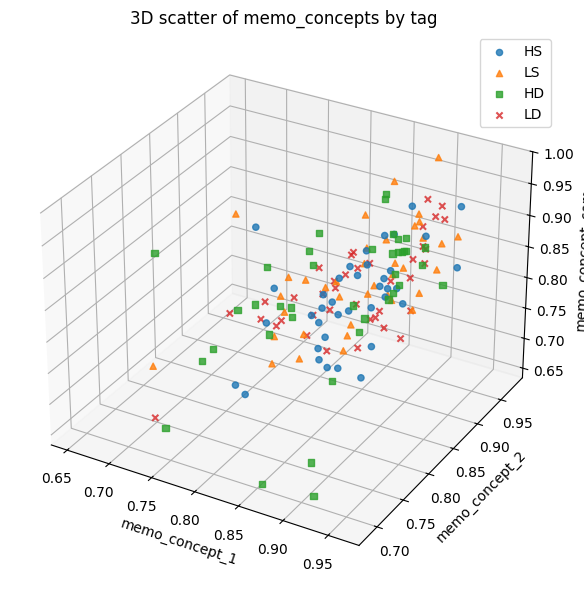

In [9]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # 仅为了触发 3D 支持
from collections import defaultdict

# 1. 先按 tag 分组
grouped = defaultdict(list)
for item in results:
    grouped[item['tag']].append(item)

# 2. 准备 3D 画布
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# 3. 为不同 tag 设定不同颜色/标记（tag 不超过 4 个）
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']
markers = ['o', '^', 's', 'x']

for (tag, items), color, marker in zip(grouped.items(), colors, markers):
    xs = [d['memo_concept_1'] for d in items]
    ys = [d['memo_concept_2'] for d in items]
    zs = [d['memo_concept_com'] for d in items]
    
    ax.scatter(xs, ys, zs,
               label=tag,
               c=color,
               marker=marker,
               alpha=0.8)

# 4. 设置坐标轴和标题
ax.set_xlabel('memo_concept_1')
ax.set_ylabel('memo_concept_2')
ax.set_zlabel('memo_concept_com')
ax.set_title('3D scatter of memo_concepts by tag')
ax.legend()

plt.tight_layout()
plt.show()

#### statistical analysis

In [10]:
data_lst = [tagged_memo[i] for i in index]

In [11]:
data_lst

[{'grapefruit_10s': 0.9097368717193604,
  'granola_07s': 0.8094499111175537,
  'grapefruit_10s&&granola_07s_00001_': 0.8573886156082153,
  'group': 'HS',
  'CLIP': {'sAB': 0.7229911684989929,
   'sAC': 0.7291331887245178,
   'sBC': 0.9448032975196838,
   'comb_score': 0.6149237953983744,
   'tag': 'combination'},
  'CLIP_pca': {'sAB': 0.2521896958351135,
   'sAC': 0.2883053123950958,
   'sBC': 0.8965233564376831,
   'comb_score': 1.4611818234639422,
   'tag': 'combination'},
  'Pixel': {'sAB': 0.8333032131195068,
   'sAC': 0.8291469216346741,
   'sBC': 0.9896306395530701,
   'comb_score': 0.09646752419852866,
   'tag': 'combination'},
  'Pixel_pca': {'sAB': 0.051765576004981995,
   'sAC': 0.12896424531936646,
   'sBC': 0.971914529800415,
   'comb_score': 0.2889705765110073,
   'tag': 'combination'},
  'Semantic_Similarity': 0.9748241713933846},
 {'grapefruit_18n': 0.9278603196144104,
  'granola_11s': 0.8811565041542053,
  'grapefruit_18n&&granola_11s_00001_': 0.8871610164642334,
  'gro

In [12]:

columns = [
    "mem_C",
    "max_memAB",
    "min_memAB",
    "avg_memAB",
    "sim_AC",
    "sim_BC",
    "max_simACBC",
    "min_simACBC",
    "mem_max_simACBC",
    "mem_min_simACBC",
    "semantic_similarity",
    "category"
    ]
index = []
data = []

for dict_tmp in data_lst:
    keys_lst = list(dict_tmp.keys())
    index.append(keys_lst[2][:-7]) # name of image C: A&&B

    data_tmp = []
    mem_A = dict_tmp[keys_lst[0]] # mem_A
    mem_B = dict_tmp[keys_lst[1]] # mem_B

    mem_C = dict_tmp[keys_lst[2]] # mem_C
    max_memA_memB = max(mem_A, mem_B) # max(mem_A, mem_B)
    min_memA_memB = min(mem_A, mem_B) # min(mem_A, mem_B)
    avg_memA_memB = (mem_A + mem_B) / 2 # Avg(mem_A, mem_B)

    model_results = dict_tmp[tag_method_lst[method_tag]]
    sAC = model_results["sAC"] # similarity_AC
    sBC = model_results["sBC"] # similarity_BC
    # max(sim(AC, BC))    min(sim(AC, BC))
    # Mem(max(sim(A,B))   Mem(min(sim(A,B))
    if sAC >= sBC:
        max_sim, min_sim = sAC, sBC
        mem_maxSim, mem_minSim = mem_A, mem_B
    else:
        max_sim, min_sim = sBC, sAC
        mem_maxSim, mem_minSim = mem_B, mem_A

    semantic_similarity = dict_tmp["Semantic_Similarity"] # semantic_similarity
    category = dict_tmp["group"] # category

    data_tmp.extend([mem_C,
                     max_memA_memB,
                     min_memA_memB,
                     avg_memA_memB,
                     sAC,
                     sBC,
                     max_sim,
                     min_sim,
                     mem_maxSim,
                     mem_minSim,
                     semantic_similarity,
                     category])
    data.append(data_tmp)


In [13]:
import pandas as pd

df = pd.DataFrame(data, columns=columns, index=index)
df.head()

,mem_C,max_memAB,min_memAB,avg_memAB,sim_AC,sim_BC,max_simACBC,min_simACBC,mem_max_simACBC,mem_min_simACBC,semantic_similarity,category
grapefruit_10s&&granola_07s,0.857389,0.909737,0.809450,0.859593,0.729133,0.944803,0.944803,0.729133,0.809450,0.909737,0.974824,HS
grapefruit_18n&&granola_11s,0.887161,0.927860,0.881157,0.904508,0.761477,0.764407,0.764407,0.761477,0.881157,0.927860,0.974824,HS
grapefruit_06s&&granola_08s,0.864956,0.963548,0.829648,0.896598,0.897393,0.854021,0.897393,0.854021,0.963548,0.829648,0.974824,HS
grapefruit_04s&&granola_17s,0.877763,0.891631,0.887376,0.889504,0.866846,0.836677,0.866846,0.836677,0.891631,0.887376,0.974824,HS
grapefruit_11s&&granola_13s,0.837836,0.924393,0.842155,0.883274,0.927856,0.770310,0.927856,0.770310,0.924393,0.842155,0.974824,HS


In [43]:
df.to_csv("restuls.csv")

In [44]:
print("whole")

formula = """
    mem_C ~ max_memAB
            + min_memAB
            + max_simACBC 
            + min_simACBC 
            + mem_max_simACBC 
            + mem_min_simACBC 
            + semantic_similarity 
    """

model = smf.ols(formula=formula, data=df)
result = model.fit()

print(result.summary())

whole
                            OLS Regression Results                            
Dep. Variable:                  mem_C   R-squared:                       0.517
Model:                            OLS   Adj. R-squared:                  0.513
Method:                 Least Squares   F-statistic:                     117.7
Date:                Fri, 12 Dec 2025   Prob (F-statistic):          9.17e-101
Time:                        21:48:22   Log-Likelihood:                 1046.0
No. Observations:                 666   AIC:                            -2078.
Df Residuals:                     659   BIC:                            -2047.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.08

When viewing the results as a whole, the pattern is the same as before

# Interesting finding:

In [41]:
import statsmodels.formula.api as smf
for i in df["category"].unique():
    print(i)
    df_tmp = df[df["category"] == i]

    formula = """
        mem_C ~ max_memAB
                + min_memAB
                + max_simACBC 
                + min_simACBC 
                + mem_max_simACBC 
                + mem_min_simACBC 
                + semantic_similarity 
        """

    model = smf.ols(formula=formula, data=df_tmp)
    result = model.fit()

    print(result.summary())

HS
                            OLS Regression Results                            
Dep. Variable:                  mem_C   R-squared:                       0.380
Model:                            OLS   Adj. R-squared:                  0.357
Method:                 Least Squares   F-statistic:                     16.57
Date:                Fri, 12 Dec 2025   Prob (F-statistic):           7.46e-15
Time:                        21:15:44   Log-Likelihood:                 265.33
No. Observations:                 169   AIC:                            -516.7
Df Residuals:                     162   BIC:                            -494.8
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.3083 

When splited into 4 groups, the patterns are different

In [ ]:
# regression model
import statsmodels.formula.api as smf

formula = """
mem_C ~ max_memAB
        + min_memAB
        + avg_memAB 
        + sim_AC 
        + sim_BC 
        + max_simACBC 
        + min_simACBC 
        + mem_max_simACBC 
        + mem_min_simACBC 
        + semantic_similarity 
        + C(category)
        + max_memAB * min_memAB
"""

model = smf.ols(formula=formula, data=df)
result = model.fit()

print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                  mem_C   R-squared:                       0.527
Model:                            OLS   Adj. R-squared:                  0.519
Method:                 Least Squares   F-statistic:                     66.30
Date:                Fri, 12 Dec 2025   Prob (F-statistic):           9.56e-99
Time:                        20:55:47   Log-Likelihood:                 1053.0
No. Observations:                 666   AIC:                            -2082.
Df Residuals:                     654   BIC:                            -2028.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              -0.3999    

In [15]:
# regression model
import statsmodels.formula.api as smf

formula = """
semantic_similarity ~ max_memAB
                    + min_memAB
                    + max_memAB * min_memAB
                    + avg_memAB 
                    + sim_AC 
                    + sim_BC 
                    + max_simACBC 
                    + min_simACBC 
                    + mem_max_simACBC 
                    + mem_min_simACBC 
        
"""

model = smf.ols(formula=formula, data=df)
result = model.fit()

print(result.summary())

                             OLS Regression Results                            
Dep. Variable:     semantic_similarity   R-squared:                       0.098
Model:                             OLS   Adj. R-squared:                  0.089
Method:                  Least Squares   F-statistic:                     10.27
Date:                 Fri, 12 Dec 2025   Prob (F-statistic):           3.02e-12
Time:                         20:55:47   Log-Likelihood:                -368.96
No. Observations:                  666   AIC:                             753.9
Df Residuals:                      658   BIC:                             789.9
Df Model:                            7                                         
Covariance Type:             nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              -

In [16]:
# regression model
import statsmodels.formula.api as smf

formula = """
mem_C ~ max_memAB
        + min_memAB
        + avg_memAB 
        + sim_AC 
        + sim_BC 
        + max_simACBC 
        + min_simACBC 
        + mem_max_simACBC 
        + mem_min_simACBC 
        + semantic_similarity 
        + C(category)
        + max_memAB * min_memAB * semantic_similarity 
"""

model = smf.ols(formula=formula, data=df)
result = model.fit()

print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                  mem_C   R-squared:                       0.533
Model:                            OLS   Adj. R-squared:                  0.523
Method:                 Least Squares   F-statistic:                     52.99
Date:                Fri, 12 Dec 2025   Prob (F-statistic):           1.23e-97
Time:                        20:55:47   Log-Likelihood:                 1056.8
No. Observations:                 666   AIC:                            -2084.
Df Residuals:                     651   BIC:                            -2016.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                                              coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------

In [24]:
# regression model
import statsmodels.formula.api as smf

formula = """
mem_C ~ min_memAB
"""

model = smf.ols(formula=formula, data=df)
result = model.fit()

print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                  mem_C   R-squared:                       0.379
Model:                            OLS   Adj. R-squared:                  0.378
Method:                 Least Squares   F-statistic:                     404.7
Date:                Fri, 12 Dec 2025   Prob (F-statistic):           1.19e-70
Time:                        21:03:00   Log-Likelihood:                 962.01
No. Observations:                 666   AIC:                            -1920.
Df Residuals:                     664   BIC:                            -1911.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.3063      0.026     11.581      0.0

In [33]:
# regression model
import statsmodels.formula.api as smf

formula = """
mem_C ~ max_memAB
        + mem_max_simACBC 
        + C(category) * max_memAB
"""

model = smf.ols(formula=formula, data=df)
result = model.fit()

print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                  mem_C   R-squared:                       0.516
Model:                            OLS   Adj. R-squared:                  0.510
Method:                 Least Squares   F-statistic:                     87.69
Date:                Fri, 12 Dec 2025   Prob (F-statistic):           1.92e-98
Time:                        21:09:49   Log-Likelihood:                 1045.4
No. Observations:                 666   AIC:                            -2073.
Df Residuals:                     657   BIC:                            -2032.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

In [18]:
df.columns

Index(['mem_C', 'max_memAB', 'min_memAB', 'avg_memAB', 'sim_AC', 'sim_BC',
       'max_simACBC', 'min_simACBC', 'mem_max_simACBC', 'mem_min_simACBC',
       'semantic_similarity', 'category'],
      dtype='object')

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline

# 1. x, y
y = df['mem_C']
X = df.drop(columns=['mem_C'])

# 2. category vs. numerical
categorical_cols = ['category']
numeric_cols = [c for c in X.columns if c not in categorical_cols]

# 3. one-hot, passthrough
preprocess = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first'), categorical_cols),  # category -> one-hot
        ('num', 'passthrough', numeric_cols)                    # number -> passthrough
    ]
)

# 4. pipeline
model = Pipeline(steps=[
    ('preprocess', preprocess),
    ('regressor', LinearRegression())
])

# 5. train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0
)

# 6. fit
model.fit(X_train, y_train)

print("Train R^2:", model.score(X_train, y_train))
print("Test  R^2:", model.score(X_test, y_test))

Train R^2: 0.5269257978597707
Test  R^2: 0.5111502562826296


In [20]:
import numpy as np

ohe = model.named_steps['preprocess'].named_transformers_['cat']
cat_feature_names = ohe.get_feature_names_out(categorical_cols)  # e.g. ['Category_HS', 'Category_LS', ...]

feature_names = np.concatenate([cat_feature_names, np.array(numeric_cols)])

coefs = model.named_steps['regressor'].coef_

coef_series = pd.Series(coefs, index=feature_names)
print(coef_series)

category_HS            0.226834
category_LD            0.003810
category_LS            0.200242
max_memAB              0.258250
min_memAB              0.090267
avg_memAB              0.174258
sim_AC                 0.019795
sim_BC                 0.012030
max_simACBC            0.007385
min_simACBC            0.024441
mem_max_simACBC        0.423366
mem_min_simACBC       -0.074849
semantic_similarity   -0.244364
dtype: float64


## Based on current exploration + Reflection
The deeper social-scientific value of this ITR is not just “better prediction,” but better attribution: if I claim the 4 groups differ in meaningful ways, I need to show those differences are not simply due to confounders like memorability baselines (mem_A, mem_B) or similarity structure (sim_AB, sim_AC, …). Nearest-neighbor matching is a methodological commitment to a particular cultural-science norm: don’t confuse structural differences in my data pipeline with differences in the phenomenon itself.

In my project, “group” is not merely a label—it encodes a generative process (e.g., different image-generation conditions, prompt structures, or transformation regimes). If group differences persist after balancing on mem_A, mem_B, and similarity covariates, then I can plausibly argue that the generative process changes outcomes in a way consistent with a “rule.” But if group differences vanish after balancing, then what I thought was a rule is more likely a selection artifact: certain groups might systematically contain images that are already easier/harder by intrinsic memorability or are positioned differently in embedding space. This is culturally important because it changes the story from “the method produces different kinds of images” to “the method samples different parts of visual culture.”

At the same time, my decision to stop early—because within-group regressions already produced the result—raises a caution: regression can adjust for measured confounders, but it doesn’t automatically guarantee comparability across groups. Matching is valuable precisely because it forces a concrete overlap question: Do comparable cases exist across groups? Recent work emphasizes that NN matching can be theoretically principled and can even be extended cleanly to multi-group settings (which maps to my 4-group comparison). With larger image quantities, matching becomes not just feasible but epistemically stronger: it can help me make claims like “Among images with similar memorability baselines and similarity structure, group membership still shifts outcomes,” which is closer to a causal rule than “the regression coefficient is significant.”

Finally, there’s a broader implication: if we treat group differences as causal without checking overlap/balance, we risk encoding pipeline-driven biases as “truth” about cognition or culture. Scaling up the dataset is not just for statistical power—it’s what enables stronger causal design choices, clearer rules, and more defensible claims about how computational generation relates to memorability and visual meaning.

----

## Bibliography
Lin, Z., Ding, P., & Han, F. (2023). Estimation Based on Nearest Neighbor Matching: From Density Ratio to Average Treatment Effect. Econometrica, 91(6), 2187–2217. https://doi.org/10.3982/ECTA20598

Scotina, A. D., Beaudoin, F. L., & Gutman, R. (2020). Matching estimators for causal effects of multiple treatments. Statistical Methods in Medical Research, 29(4), 1051–1066. https://doi.org/10.1177/0962280219850858

Zhang, Y., Xu, T., Cheng, D., Li, J., Liu, L., Xu, Z., & Feng, Z. (2025). Data-driven learning optimal K values for K-nearest neighbour matching in causal inference. Data Mining and Knowledge Discovery, 39(4), 35. https://doi.org/10.1007/s10618-025-01107-5

